In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [3]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import the files from google drive
import gzip
file1 = gzip.open('/content/drive/MyDrive/train-images-idx3-ubyte.gz','r')
file2 = gzip.open('/content/drive/MyDrive/train-labels-idx1-ubyte.gz','r')
file3 = gzip.open('/content/drive/MyDrive/t10k-images-idx3-ubyte.gz','r')
file4 = gzip.open('/content/drive/MyDrive/t10k-labels-idx1-ubyte.gz','r')

image_size = 28
train_images = 60000
test_images = 10000

# Read image
file1.read(16)
buf = file1.read(image_size * image_size * train_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
train_data1 = data.reshape(train_images, image_size, image_size)

# read label
file2.read(8)
array1 = []
for i in range(train_images):   
    buf = file2.read(1)
    array1.append(np.frombuffer(buf, dtype=np.uint8).astype(np.int64).tolist())

file3.read(16)
buf = file3.read(image_size * image_size * test_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data1 = data.reshape(test_images, image_size, image_size)

file4.read(8)
array2 =[]
for i in range(0,test_images):   
    buf = file4.read(1)
    array2.append(np.frombuffer(buf, dtype=np.uint8).astype(np.int64).tolist())


In [9]:
# Data preprocessing
def preProcess(num, X, y):
  train_data = []
  y_train = []
  for i in range(num):
    # keep if trouser or pullover
    if (y[i][0] == 1) or (y[i][0] == 2):
      train_data.append(X[i])

      # append the values of target
      y_train.append(y[i][0] - 1)
  
  return train_data, y_train

# Preprocess the data
X_train, y_train = preProcess(train_images, train_data1, array1)
X_test, y_test = preProcess(test_images, test_data1, array2)

print("The number of samples left in training data is: " , len(X_train))

The number of samples left in training data is:  12000


In [11]:
# Binarize the data
def binarize(data):
  n = len(data)
  new_data = np.zeros((n, 784))

  for i in range(n):
    new_data[i] = data[i].ravel()
    new_data[i] = [int(round(i/255)) for i in new_data[i]]
  return new_data

X_train = binarize(X_train)
X_test = binarize(X_test)


In [16]:
class naiveBayesClass:
  def fit(self, X, y):
    n_samples, n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    self._features = np.zeros((n_classes, n_features), dtype = np.float64)
    self._classcs = np.zeros((n_classes, 1), dtype = np.int64)
    self._priors = np.zeros(n_classes, dtype = np.float64)

    # calculate the priors
    for c in self._classes:
      Xc = X[c == y]
      self._features[c, :] = Xc.sum(axis = 0)
      self._priors[c] = Xc.shape[0]/float(n_samples)
      
      if c == 0:
        self._classcs[0] = Xc.shape[0]
      
      if c == 1:
        self._classcs[1] = Xc.shape[0]
      

  def predict(self, X):
    y_pred = [self._predx(x) for x in X]
    return y_pred

  def _predx(self, x):
    posts = []
    for id, c in enumerate(self._classes):

      # calculate the prior probability
      prior = np.log(self._priors[id])
      classConditionals = np.sum(np.log(self._pdf(id, x)))

      # calculate the posterior probability
      posterior = prior + classConditionals
      posts.append(posterior)
    
    # argmax to get the class
    return self._classes[np.argmax(posts)]
  
  def _pdf(self, class_id, x):
    
    # get the classcs and features.
    features_ = self._features[class_id]
    classcs_ = self._classcs[class_id]
    n = np.ndarray((784, 1))
    d = np.ndarray((1,1))
    
    for i in range(784):

      # assign value to n
      if x[i] == 1:
        n[i] = features_[i]

      else:
        n[i] = self._classcs[class_idx] - features_[i]
    
    d[0] = classcs_[0] + 2
    
    return (n/d)


In [19]:
def crossValidation(data, values):

  # make a list of indices.
  indices = list(zip(data, values))

  # shuffle the array
  random.shuffle(indices)
  data, values = list(zip(*indices))
  values = list(values)
  sizeData = len(data)

  # divide in 3 equal parts
  n1 = int(sizeData/3)
  n2 = int(2*sizeData/3)

  # assign to arrays.
  data1, data2, data3 = data[:n1], data[n1:n2], data[n2:]
  val1, val2, val3 = values[:n1], values[n1:n2], values[n2:]

  xlen = 4000
  ylen = 784

  # make arrays
  data1 = np.reshape(data1, (xlen, ylen))
  data2 = np.reshape(data2, (xlen, ylen))
  data3 = np.reshape(data3, (xlen, ylen))

  return data1, data2, data3, val1, val2, val3


# get three sets.
train1, train2, train3, y1, y2, y3 = crossValidation(X_train, y_train)

In [22]:
model = naiveBayesClass()

# First training data
X_train1 = np.concatenate((train1, train2))
y_train1 = np.concatenate((y1, y2))

# First testing data
X_test1 = train3
y_test1 = y3

# 1st model
model.fit(X_train1, y_train1)
y_pred1 = model.predict(X_test1)

# 2nd training data
X_train2 = np.concatenate((train3, train1))
y_train2 = np.concatenate((y3, y1))

# 2nd testing data
X_test2 = train2
y_test2 = y2

# 2nd model
model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_test2)

# 3rd training data
X_train3 = np.concatenate((train2, train3))
y_train3 = np.concatenate((y2, y3))

# 3rd testing set
X_test3 = train1
y_test3 = y1

# 3rd model
model.fit(X_train3,y_train3)
y_pred3 = model.predict(X_test3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


In [23]:
from sklearn.metrics import confusion_matrix


In [24]:
# Print confusion matrix for each validation set.
print("The confusion matrix 1:")
print(confusion_matrix(y_test1, y_pred1))
print()
print("The confusion matrix 2:")
print(confusion_matrix(y_test2, y_pred2))
print()
print("The confusion matrix 3:")
print(confusion_matrix(y_test3, y_pred3))


The confusion matrix 1:
[[1921   56]
 [ 227 1796]]

The confusion matrix 2:
[[1982   58]
 [ 199 1761]]

The confusion matrix 3:
[[1904   79]
 [ 213 1804]]


In [25]:
def plotRoc(fpr, tpr, label = None):
 plt.plot(fpr, tpr, linewidth = 2, label = label)

In [26]:
from sklearn.metrics import roc_curve


The roc curve for 1st model


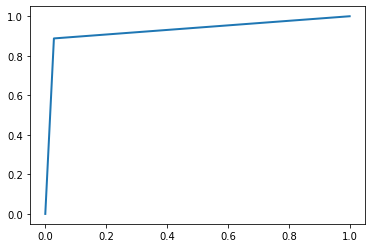

The roc curve for 2nd model


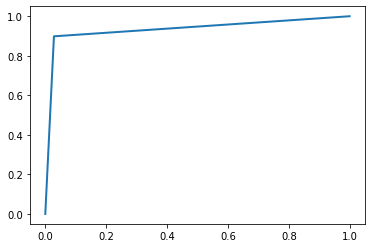

The roc curve for 3rd model


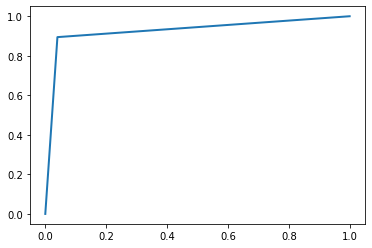

In [27]:
# Roc plot for 1st model
print("The roc curve for 1st model")
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1)
plotRoc(fpr, tpr)
plt.show()

# Roc plot for 2nd model
print("The roc curve for 2nd model")
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2)
plotRoc(fpr, tpr)
plt.show()

# Roc plot for 3rd model
print("The roc curve for 3rd model")
fpr, tpr, thresholds = roc_curve(y_test3, y_pred3)
plotRoc(fpr, tpr)
plt.show()

In [28]:
# import the scores
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [30]:
# Print the three scores for three models
print("First model")
print("Precision score: ", precision_score(y_test1, y_pred1))
print("Accuracy scores", accuracy_score(y_test2, y_pred2))
print("Recall score: ", recall_score(y_test1, y_pred1))
print()

print("Second Model")
print("Precision score: ", precision_score(y_test2, y_pred2))
print("Accuracy scores", accuracy_score(y_test1, y_pred1))
print("Recall score: ", recall_score(y_test2, y_pred2))
print()


print("Third Model")
print("Precision score: ", precision_score(y_test3, y_pred3))
print("Accuracy scores", accuracy_score(y_test3, y_pred3))
print("Recall score: ", recall_score(y_test3, y_pred3))
print()




First model
Precision score:  0.9697624190064795
Accuracy scores 0.93575
Recall score:  0.8877904102817598

Second Model
Precision score:  0.9681143485431556
Accuracy scores 0.92925
Recall score:  0.898469387755102

Third Model
Precision score:  0.9580456718003186
Accuracy scores 0.927
Recall score:  0.8943976202280615

